<a href="https://colab.research.google.com/github/clemgi0/movie-analyser_deep-learning-proyecto/blob/main/03_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Analyser | Deep Learning Final Project

In this serie of notebook, we will follow my avances for this project. Let's begin by defining it. Basically, what I want to achieve is to create a deep learning AI model using Keras and Tensorflow that could predict the success of a movie through it's resume, and some other possible input datas like the name of the movie, it's director or it's genre.

### DATASETS
https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

Features of the first dataset :

Here are it's features:

0 Poster_Link - Link of the poster that imdb using

1 Series_Title - Name of the movie

2 Released_Year - Year at which that movie released

3 Certificate - Certificate earned by that movie

4 Runtime - Total runtime of the movie

5 Genre - Genre of the movie

6 IMDB_Rating - Rating of the movie at IMDB site

7 Overview - mini story/ summary

8 Meta_score - Score earned by the movie

9 Director - Name of the Director

10, 11, 12, 13 Star1,Star2,Star3,Star4 - Name of the Stars

14 No_of_votes - Total number of votes

15 Gross - Money earned by that movie



https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset

Features of the second dataset :

0 Filmtv_id - Movie id

1 Title - Name of the movie

2 Year - Movie year of release

3 Genre - Movie genre

4 Duration - Movie duration (in min)

5 Country - Countries where the movie was filmed

6 Directors - Name of movie directors

7 Actors - Name of movie actors

8 Avg_vote - Average rating (by critics and public)

9 Critics_vote - Average vote of the critics

10 Public_vote - Average vote of the public

11 Total_vote - Total votes expressed by critics and public

12 Overview - Movie description

13 Notes - Movie notes

14 Humor - Movie humor score given by filmtv

15 Rythm - Movie rythm score given by filmtv

16 Tension - Movie tension score given by filmtv

17 Erotism - Movie erotism score given by filmtv

In [174]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import os
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

## Base architecture
In this thirs notebook, we will focus on realising a basic architecture to test out our datas. Then, we will try to implement a more complicated model architecture to intent to get the best results possible.

### Data preparation

**Here we select the dataset that we want to use (run two times so it shows "Using Colab cache...).**

In [175]:
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")
dataset = "IMDB"

Using Colab cache for faster access to the 'imdb-dataset-of-top-1000-movies-and-tv-shows' dataset.


In [177]:
path = kagglehub.dataset_download("stefanoleone992/filmtv-movies-dataset")
dataset = "FilmTV"

Using Colab cache for faster access to the 'filmtv-movies-dataset' dataset.


Here we import the datas we want and shuffle them for the reason we saw on the first notebook. We also withdraw the features that interests us.

In [ ]:
files_in_path = os.listdir(path)
csv_files = [f for f in files_in_path if f.endswith('.csv')]

if csv_files:
    data_file = os.path.join(path, csv_files[0])
    df = pd.read_csv(data_file)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the datas to avoid linear IMDB rating

    data = df.to_numpy()
    if dataset == "IMDB":
      data = data[:, [1, 5, 7, 9, 2, 6, 8]] # Title / Genre / Overview / Director / Average score / IMDB rating / meta-score
    else:
      data = data[:, [1, 3, 12, 6, 8]] # Title / Genre / Overview / Director / Average votes

    print("Data shape:", data[:3,:])
else:
    print("No CSV files found in the specified path. Please specify which file to load if it's not a CSV or has a different extension.")

Data shape: [['Svadba' 'Comedy'
  'Mishka and Tania, friends since school, are getting married. But something is wrong because the girl leaves for Moscow and disappears for a few years. Having vanished the dreams of becoming a model, she decides to return to the country to marry the good Mishka, muscular and solid worker with a clean face, still in love with her. At this point the film tells about the wedding preparations, the ceremony, the dramas and the trafficking that goes through it.'
  'Pavel Lungin' 7.0]
 ['The Phantom of Crestwood' 'Thriller'
  'Pushed by the beautiful Jenny Wren, banker Priam Andes throws a party at Crestwood, his summer residence. The girl asks Priam to also invite three wealthy men whom she intends to pluck, but her plans will be unexpectedly upset by an inexplicable death ...'
  'J. Walter Ruben' 6.5]
 ['Ragazzi della marina' 'War'
  'The cruiser "Raimondo Montecuccoli" leaves Livorno with the cadets of the Naval Academy. Among them, three sailors are worri

Here, we prepocess the datas as we did it in second notebook by cleaning, shortening, tokenizing and normalizing them (takes approximately 1min for FilmTV dataset).

In [225]:
df2 = pd.DataFrame(data)
df2 = df2.replace("nan", np.nan)   # if "nan" is a chain, we delete the row
df2 = df2.dropna()
data_clean = df2.to_numpy()

In [230]:
# Remove the rows containing nan values
df2 = pd.DataFrame(data)
df2 = df2.replace("nan", np.nan)   # if "nan" is a chain, we delete the row
df2 = df2.dropna()
data_clean = df2.to_numpy()
data_clean = data_clean[::6,:] # to reduce waiting time for model tuning


# Set variables
if dataset == "IMDB":
  ov_max_features = 5000
  ti_max_features = 1000
  ge_max_features = 23
else:
  ov_max_features = 6000
  ti_max_features = 2000
  ge_max_features = 30


# Downloading the english stopwords dictionnary and creating the remove_stowords function
nltk.download('punkt_tab')
nltk.download('stopwords')
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_all = stopwords_en
stopwords_all += nltk.corpus.stopwords.words('spanish')
stopwords_all += nltk.corpus.stopwords.words('french')
stopwords_all += nltk.corpus.stopwords.words('italian')
stopwords_all += nltk.corpus.stopwords.words('german')
stopwords_all = set(stopwords_all)

def remove_stopwords(text_list, language): # For the Overview since they are only in English
    cleaned_texts = []
    for text in text_list:
      if language == "english":
        tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stopwords_en]
      else:
        tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stopwords_all]
      cleaned_texts.append(' '.join(tokens))
    return cleaned_texts


# Tokenize Overview
data_clean[:,2] = remove_stopwords(data_clean[:,2], "english")
ov_tokenizer = Tokenizer(num_words=ov_max_features, split=' ')
ov_tokenizer.fit_on_texts(data_clean[:,2])
ov_tokenizer.word_index.update({'<pad>': 0})
ov_tokenized = ov_tokenizer.texts_to_sequences(data_clean[:,2])


# Tokenize Title
data_clean[:,0] = remove_stopwords(data_clean[:,0], "all")
ti_tokenizer = Tokenizer(num_words=ti_max_features, oov_token="<UNK>")
ti_tokenizer.fit_on_texts(data_clean[:,0])
ti_tokenized = ti_tokenizer.texts_to_sequences(data_clean[:,0])


# Labelize Director
directors_raw = data_clean[:, 3]
le_director = LabelEncoder()
di_labelized = le_director.fit_transform(directors_raw)


# Tokenize Genre
genres_split = [g.lower().split(", ") for g in data_clean[:,1]]
ge_tokenizer = Tokenizer(num_words=ge_max_features, oov_token="<UNK>")
ge_tokenizer.fit_on_texts([" ".join(g) for g in genres_split])
ge_tokenized = ge_tokenizer.texts_to_sequences([" ".join(g) for g in genres_split])


# Taking average and normalization of the scores
if dataset == "IMDB":
  data_clean[:,4] = (data_clean[:,5] + data_clean[:,6] / 10.0) / 2.0
sc_normalized = data_clean[:,4] / 10.0


# Padding the tokenized features
ov_max_len = max(len(x) for x in ov_tokenized)
ti_max_len = max(len(x) for x in ti_tokenized)
ge_max_len = max(len(x) for x in ge_tokenized)

ov_padded = pad_sequences(ov_tokenized, maxlen=ov_max_len)
ti_padded = pad_sequences(ti_tokenized, maxlen=ti_max_len)
ge_padded = pad_sequences(ge_tokenized, maxlen=ge_max_len)


# Splitting the datas
nb_train_data = int(0.8*len(data_clean[:,0]))

x_train_overview = ov_padded[:nb_train_data,:]
x_train_title = ti_padded[:nb_train_data,:]
x_train_director = di_labelized[:nb_train_data]
x_train_genre = ge_padded[:nb_train_data,:]
y_train_score = np.array(sc_normalized[:nb_train_data], dtype=np.float32)

x_test_overview = ov_padded[nb_train_data:,:]
x_test_title = ti_padded[nb_train_data:,:]
x_test_director = di_labelized[nb_train_data:]
x_test_genre = ge_padded[nb_train_data:,:]
y_test_score = np.array(sc_normalized[nb_train_data:], dtype=np.float32)
print("Final data prepared for the", dataset, "dataset:\n\nOverview\n", ov_padded[:3,:],"\nTitle\n", ti_padded[:3,:],"\nDirector\n" ,di_labelized[:3],"\nGenre\n" ,ge_padded[:3,:],"\nScore\n" ,sc_normalized[:3])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Final data prepared for the FilmTV dataset:

Overview
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   

In [231]:
print("Maximum length of Overview / Title / Genre for the", dataset, "dataset:", ov_max_len, "/", ti_max_len, "/", ge_max_len)

Maximum length of Overview / Title / Genre for the FilmTV dataset: 227 / 13 / 3


Here, we finish to prepare our datas that will train our model. For the IMDB dataset, the maximum length of an shortened overview is 34 for the IMDB dataset so we choose a padding sequence of 40 to be sure that we don't loose word and we follow the same logic for the FilmTV dataset (for which the max_len is 331).

### Metrics used

To compare our model, we will use three metrics, the first one MAE (mean absolute error) gives us the mean error by our model. Then the RMSE (root mean square error) will show us if there are predictions that are far from the score target (very likely since there is no "magical formula" for a good movie). The third one, the R² (determination coefficient) measures the part of the variance showed by our predictions.

In [232]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

### First model

Here, we create our first model, something really simple with a GlobalAveragePooling1D layer, just to see what we can get from the preprocessing of our datas.

Input : overview → Embedding → GlobalAveragePooling1D → Dense(64)

Dense(64) → Output (score)

In [183]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense

# --- Architecture ---
def getModel1(max_len, max_features, embedding_dim):
  inputs = Input(shape=(max_len,))
  x = Embedding(max_features, embedding_dim)(inputs)
  x = GlobalAveragePooling1D()(x)
  x = Dense(64, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)

  return Model(inputs, outputs)

In [187]:
embedding_dim = 64

model1 = getModel1(ov_max_len, ov_max_features, embedding_dim)

model1.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)

model1.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 297)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_46 (Embedding)        │ (None, 297, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,225 (4.90 MB)

 Trainable params: 1,284,225 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
model1.fit(x_train_overview, y_train_score, epochs=1, batch_size=256, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0204 - mae: 0.1160 - r2_score: -268.3111 - rmse: 0.1428


In [190]:
loss, mae, rmse, r2 = model1.evaluate(x_test_overview, y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0200 - mae: 0.1139 - r2_score: -31.9750 - rmse: 0.1414
MSE (loss) : 0.019641291350126266
MAE : 0.1132066622376442
RMSE : 0.1401473879814148
R2 Score : -32.038082122802734


Finally, we can see that this model is doing a pretty miserable job at predicting our movies score but we knew it would be like that since it can't encapsulate the sense of the Overview without an RNN layer. So, this is what our next model will include.

In [192]:
y_pred = model1.predict(x_test_overview)

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Overview: In an old theater of the sixties, the actress Piera Degli Esposti retraces her l ...
Real rating : 0.43  – Prediction : 0.57120115
---
Overview: Martin and Laura Burney have been married for more than three years, but for her ...
Real rating : 0.52  – Prediction : 0.5843757
---
Overview: We are in 1694, in England. Neville, an ambitious painter, accepts a curious con ...
Real rating : 0.41  – Prediction : 0.5795189
---
Overview: Over the course of a single day, you follow the sun's course from the highest mo ...
Real rating : 0.46  – Prediction : 0.5786341
---
Overview: Twenty years after finishing her studies, Anna has to go on a reunion with her f ...
Real rating : 0.53  – Prediction : 0.5793798
---
Overview: In Ajo City, in southern Arizona, an irrepressible proliferation of rabbits dest ...
Real rating : 0.5  – Prediction : 0.585818
---
Overview: A gravedigger, while about to dig a grave witnesses an accident in which a cycli ...
R

### Second model

Input : overview → Embedding → LSTM → Dense(64)

Dense(64) → Output (score)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Concatenate, Flatten)

def getModel2(embedding_dim):
  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")

  # ---- Overview branch (RNN) ----
  x = Embedding(ov_max_features, embedding_dim, name="embedding")(overview_in)
  x = LSTM(64, return_sequences=False, name="LSTM")(x)

  # ---- Final regressor ----
  x = Dense(64, activation='relu', name="hidden_dense64")(x)
  output = Dense(1, activation='sigmoid', name="score_output")(x)

  return Model(
      inputs=overview_in,
      outputs=output
  )

In [ ]:
embedding_dim = 64

model2 = getModel2(embedding_dim)
model2.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)
model2.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ overview_input (InputLayer)     │ (None, 322)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 322, 64)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense64 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ score_output (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,237,249 (12.35 MB)

 Trainable params: 3,237,249 (12.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.fit(x_train_overview, y_train_score, epochs=1, batch_size=256, verbose=1)

Epoch 1/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 147s 289ms/step - loss: 0.0192 - mae: 0.1125
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - loss: 0.0122 - mae: 0.0857
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 145s 284ms/step - loss: 0.0071 - mae: 0.0641
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 137s 276ms/step - loss: 0.0041 - mae: 0.0478
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - loss: 0.0025 - mae: 0.0377
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 139s 279ms/step - loss: 0.0018 - mae: 0.0312
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 137s 277ms/step - loss: 0.0013 - mae: 0.0269
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 147s 295ms/step - loss: 0.0010 - mae: 0.0240
Epoch 9/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 198s 287ms/step - loss: 8.4283e-04 - mae: 0.0219
Epoch 10/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 203s 289ms/step - loss: 7.7453e-04 - mae: 0.0209


In [ ]:
loss, mae, rmse, r2 = model2.evaluate(x_test_overview, y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - loss: 0.0240 - mae: 0.1228
MSE (loss) : 0.023741643875837326
MAE : 0.1218433603644371


In [ ]:
y_pred = model2.predict(x_test_overview)

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step
Overview: In an old theater of the sixties, the actress Piera Degli Esposti retraces her l ...
Real rating : 0.43  – Prediction : 0.64416426
---
Overview: Martin and Laura Burney have been married for more than three years, but for her ...
Real rating : 0.52  – Prediction : 0.30024314
---
Overview: We are in 1694, in England. Neville, an ambitious painter, accepts a curious con ...
Real rating : 0.41  – Prediction : 0.36196965
---
Overview: Over the course of a single day, you follow the sun's course from the highest mo ...
Real rating : 0.46  – Prediction : 0.49203116
---
Overview: Twenty years after finishing her studies, Anna has to go on a reunion with her f ...
Real rating : 0.53  – Prediction : 0.4984886
---
Overview: In Ajo City, in southern Arizona, an irrepressible proliferation of rabbits dest ...
Real rating : 0.5  – Prediction : 0.5647663
---
Overview: A gravedigger, while about to dig a grave witnesses an accident in which a cycli

### Third model

Input 1 : overview → Embedding → LSTM → Dense(64)

Input 2 : title → Embedding → LSTM → Dense(16)

Input 3 : genre → Embedding → Flatten → Dense(8)

Input 4 : director → Embedding → Flatten → Dense(16)

Concatenate the 4 branches

Dense(64) → Output (score)

In [233]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, LSTM, Dense, Concatenate, Flatten)

def getModel3(embedding_dim):
  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")
  title_in    = Input(shape=(ti_max_len,), name="title_input")
  genre_in    = Input(shape=(ge_max_len,), name="genre_input")
  director_in = Input(shape=(1,), name="director_input")

  # ---- Overview branch (RNN) ----
  x = Embedding(ov_max_features, embedding_dim, name="ov_embedding")(overview_in)
  x = LSTM(64, return_sequences=False, name="ov_LSTM")(x)
  x = Dense(64, activation='relu', name="ov_dense64")(x)

  # ---- Title embedding ----
  title_emb = Embedding(ti_max_features, output_dim=16, name="ti_embedding")(title_in)
  title_emb = LSTM(16, return_sequences=False, name="ti_LSTM")(title_emb)
  title_emb = Dense(16, activation='relu', name="ti_dense16")(title_emb)

  # ---- Genre embedding ----
  genre_emb = Embedding(ge_max_features, output_dim=8, name="ge_embedding")(genre_in)
  genre_emb = Flatten(name="ge_flatten")(genre_emb)
  genre_emb = Dense(8, activation='relu', name="ge_dense8")(genre_emb)

  # ---- Director dense ----
  director_emb = Embedding(len(le_director.classes_), output_dim=16)(director_in)
  director_emb = Flatten(name="di_flatten")(director_emb)
  director_emb = Dense(16, activation='relu', name="di_dense16")(director_emb)

  # ---- Fusion ----
  merged = Concatenate()([
      x,
      title_emb,
      genre_emb,
      director_emb
  ])

  # ---- Final regressor ----
  hidden = Dense(64, activation='relu', name="hidden_dense64")(merged)
  output = Dense(1, activation='sigmoid', name="score_output")(hidden)

  return Model(
      inputs=[overview_in, title_in, genre_in, director_in],
      outputs=output
  )

In [234]:
embedding_dim = 64

model3 = getModel3(embedding_dim)
model3.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
    ]
)
model3.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ overview_input      │ (None, 227)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_embedding        │ (None, 227, 64)   │    384,000 │ overview_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_embedding        │ (None, 13, 16)    │     32,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_embedding        │ (None, 3, 8)      │        240 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_52        │ (None, 1, 16)     │     70,080 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_LSTM (LSTM)      │ (None, 64)        │     33,024 │ ov_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_LSTM (LSTM)      │ (None, 16)        │      2,112 │ ti_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_flatten          │ (None, 24)        │          0 │ ge_embedding[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_flatten          │ (None, 16)        │          0 │ embedding_52[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_dense64 (Dense)  │ (None, 64)        │      4,160 │ ov_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_dense16 (Dense)  │ (None, 16)        │        272 │ ti_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_dense8 (Dense)   │ (None, 8)         │        200 │ ge_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_dense16 (Dense)  │ (None, 16)        │        272 │ di_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 104)       │          0 │ ov_dense64[0][0], │
│ (Concatenate)       │                   │            │ ti_dense16[0][0], │
│                     │                   │            │ ge_dense8[0][0],  │
│                     │                   │            │ di_dense16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense64      │ (None, 64)        │      6,720 │ concatenate_22[0… │
│ (Dense)             │                   │            │                 

 Total params: 533,145 (2.03 MB)

 Trainable params: 533,145 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [239]:
model3.fit([x_train_overview, x_train_title, x_train_genre, x_train_director], y_train_score, epochs=3, batch_size=256, verbose=1)

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 781ms/step - loss: 0.0175 - mae: 0.1068 - r2_score: -261.0583 - rmse: 0.1323
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 678ms/step - loss: 0.0153 - mae: 0.0987 - r2_score: -278.1852 - rmse: 0.1237
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 707ms/step - loss: 0.0098 - mae: 0.0764 - r2_score: -352.6264 - rmse: 0.0990


With this model, we can see that the predictions already become better, and this is more noticeable for the FilmTV dataset since it is a much bigger dataset.

In [241]:
loss, mae, rmse, r2 = model3.evaluate([x_test_overview, x_test_title, x_test_genre, x_test_director], y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0182 - mae: 0.1070 - r2_score: -41.1768 - rmse: 0.1347
MSE (loss) : 0.01760353520512581
MAE : 0.10541919618844986
RMSE : 0.1326783150434494
R2 Score : -41.796146392822266


In [237]:
y_pred = model3.predict([x_test_overview, x_test_title, x_test_genre, x_test_director])

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.56199104
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.5966668
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.5716248
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.5620886
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.5493598
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.57288605
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...

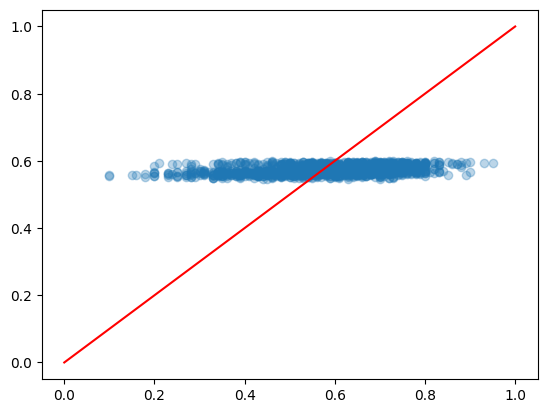

In [242]:
plt.scatter(y_test_score, y_pred, alpha=0.3)
plt.plot([0,1],[0,1], color='red')

### Fourth model

Input 1 : overview → Embedding → LSTM → Dense(64)

Input 2 : title → Embedding → LSTM → Dense(16)

Input 3 : genre → Embedding → Flatten → Dense(8)

Input 4 : director → Embedding → Flatten → Dense(16)

Concatenate the 4 branches

Dense(64) → Output (score)

In [250]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, GRU, Dense, Concatenate, Flatten, Dropout)

def getModel4(embedding_dim):
  # ---- Inputs ----
  overview_in = Input(shape=(ov_max_len,), name="overview_input")
  title_in    = Input(shape=(ti_max_len,), name="title_input")
  genre_in    = Input(shape=(ge_max_len,), name="genre_input")
  director_in = Input(shape=(1,), name="director_input")

  # ---- Overview branch (RNN) ----
  x = Embedding(ov_max_features, embedding_dim, name="ov_embedding")(overview_in)
  x = GRU(64, dropout=0.2, name="ov_LSTM")(x)
  x = Dense(64, activation='relu', name="ov_dense64")(x)

  # ---- Title embedding ----
  title_emb = Embedding(ti_max_features, output_dim=16, name="ti_embedding")(title_in)
  title_emb = GRU(16, dropout=0.2, name="ti_LSTM")(title_emb)
  title_emb = Dense(16, activation='relu', name="ti_dense16")(title_emb)

  # ---- Genre embedding ----
  genre_emb = Embedding(ge_max_features, output_dim=8, name="ge_embedding")(genre_in)
  genre_emb = Flatten(name="ge_flatten")(genre_emb)
  genre_emb = Dense(8, activation='relu', name="ge_dense8")(genre_emb)

  # ---- Director dense ----
  director_emb = Embedding(len(le_director.classes_), output_dim=16)(director_in)
  director_emb = Flatten(name="di_flatten")(director_emb)
  director_emb = Dense(16, activation='relu', name="di_dense16")(director_emb)

  # ---- Fusion ----
  merged = Concatenate()([
      x,
      title_emb,
      genre_emb,
      director_emb
  ])

  # ---- Final regressor ----
  hidden = Dense(64, activation='relu', name="hidden_dense64")(merged)
  hidden = Dropout(0.3)(hidden)
  output = Dense(1, activation='sigmoid', name="score_output")(hidden)

  return Model(
      inputs=[overview_in, title_in, genre_in, director_in],
      outputs=output
  )

In [251]:
embedding_dim = 64

model4 = getModel4(embedding_dim)
model4.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_score,
   ]
)
model4.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ overview_input      │ (None, 227)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_embedding        │ (None, 227, 64)   │    384,000 │ overview_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_embedding        │ (None, 13, 16)    │     32,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_embedding        │ (None, 3, 8)      │        240 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_54        │ (None, 1, 16)     │     70,080 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_LSTM (GRU)       │ (None, 64)        │     24,960 │ ov_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_LSTM (GRU)       │ (None, 16)        │      1,632 │ ti_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_flatten          │ (None, 24)        │          0 │ ge_embedding[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_flatten          │ (None, 16)        │          0 │ embedding_54[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ov_dense64 (Dense)  │ (None, 64)        │      4,160 │ ov_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ti_dense16 (Dense)  │ (None, 16)        │        272 │ ti_LSTM[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ge_dense8 (Dense)   │ (None, 8)         │        200 │ ge_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ di_dense16 (Dense)  │ (None, 16)        │        272 │ di_flatten[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 104)       │          0 │ ov_dense64[0][0], │
│ (Concatenate)       │                   │            │ ti_dense16[0][0], │
│                     │                   │            │ ge_dense8[0][0],  │
│                     │                   │            │ di_dense16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_dense64      │ (None, 64)        │      6,720 │ concatenate_24[0… │
│ (Dense)             │                   │            │                 

 Total params: 524,601 (2.00 MB)

 Trainable params: 524,601 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [252]:
model4.fit([x_train_overview, x_train_title, x_train_genre, x_train_director], y_train_score, epochs=10, batch_size=256, verbose=1)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 763ms/step - loss: 0.0216 - mae: 0.1210 - r2_score: -296.4612 - rmse: 0.1469
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step - loss: 0.0186 - mae: 0.1107 - r2_score: -260.2233 - rmse: 0.1365
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 751ms/step - loss: 0.0166 - mae: 0.1022 - r2_score: -263.9770 - rmse: 0.1286
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 885ms/step - loss: 0.0116 - mae: 0.0825 - r2_score: -313.9886 - rmse: 0.1078
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 742ms/step - loss: 0.0075 - mae: 0.0655 - r2_score: -378.1487 - rmse: 0.0868
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 721ms/step - loss: 0.0041 - mae: 0.0485 - r2_score: -441.1340 - rmse: 0.0642
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - loss: 0.0029 - mae: 0.0403 - r2_score: -464.6934 - rmse: 0.0534
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 795ms/step - loss: 0.0021 - mae: 0.0349 - r2_score: -478.3947 - rmse: 0.0462
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 716ms/

In [253]:
loss, mae, rmse, r2 = model4.evaluate([x_test_overview, x_test_title, x_test_genre, x_test_director], y_test_score, verbose=1)
print("MSE (loss) :", loss)
print("MAE :", mae)
print("RMSE :", rmse)
print("R2 Score :", r2)

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0198 - mae: 0.1111 - r2_score: -48.9065 - rmse: 0.1407
MSE (loss) : 0.019440656527876854
MAE : 0.11005265265703201
RMSE : 0.1394297480583191
R2 Score : -48.812347412109375


In [254]:
y_pred = model4.predict([x_test_overview, x_test_title, x_test_genre, x_test_director])

for i in range(10):
    print("Overview:", data[nb_train_data+i, 2][:80], "...")
    print("Real rating :", y_test_score[i], " – Prediction :", y_pred[i][0])
    print("---")

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Overview: Rich has decided to leave the world of crime behind for good; now he has started ...
Real rating : 0.52  – Prediction : 0.6430558
---
Overview: Alexandre, an instructor at the Canadian customs institute, finds himself under  ...
Real rating : 0.46  – Prediction : 0.56111234
---
Overview: Rémy, a former university professor and great womanizer, has cancer. His son Séb ...
Real rating : 0.72  – Prediction : 0.6408017
---
Overview: The King divides his kingdom between his three daughters. Having grown old, he i ...
Real rating : 0.68  – Prediction : 0.63173044
---
Overview: It is a special, one of the few shot by Totò for TV shortly before his death, in ...
Real rating : 0.33  – Prediction : 0.33456853
---
Overview: A thief, Frankie Connor, kidnaps Barbara Blandish, the young daughter of a billi ...
Real rating : 0.55  – Prediction : 0.578249
---
Overview: Guitarist David goes to Julia's house who asked him to give lessons to his daugh ...

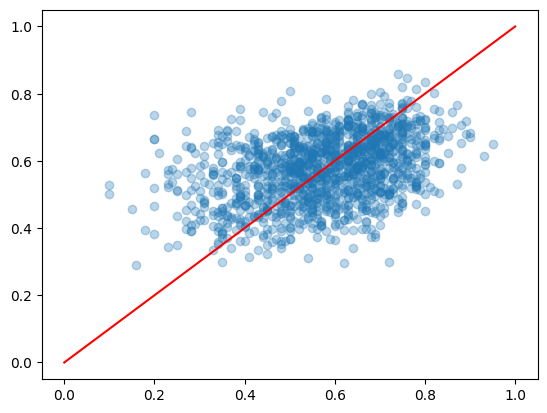

In [255]:
plt.scatter(y_test_score, y_pred, alpha=0.3)
plt.plot([0,1],[0,1], color='red')